In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import os

In [2]:
folders = ["result_sf1/", "result_sf2/", "result_sf5/"]
scales = ["sf1", "sf2", "sf5"]
variations = ["all", "dates_text", "dates", "no_index", "numbers_dates", "numbers_text", "numbers", "text"]

In [3]:
folder = "result_sf1/"
file = "index_stats_numbers.csv"
kb_in_one_mb = 1024
bytes_in_one_mb = 1_048_576
mb_in_one_gb = 1024

In [4]:
df = pd.read_csv(folder+file)

In [5]:
df.dropna(inplace=True)

In [6]:
def to_mb(row):
   units = ["kB", "bytes", "GB"]
   if not any(unit in row for unit in units):
      return row
   
   splitted = row.split()
   number = float(splitted[0])
   
   if "kB" in row:
      mb = number / kb_in_one_mb
   elif "GB" in row:
      mb = number * mb_in_one_gb
   else: # bytes
      mb = number / bytes_in_one_mb
   
   return str(mb) + " MB"

In [7]:
def clean_mb_to_number(row):
   
   if "MB" not in row:
      return row
   
   row = row.replace("MB", "").strip()
   return float(row)

In [8]:
# columns that can contain kb
kb_columns = ["Total Size","Total Size of all Indexes", "Table Size", "Index Size"]
# Columns that 
mb_columns = ["Total Size MB","Total Size of all Indexes MB", "Table Size MB", "Index Size MB"]


In [9]:
def drop_and_convert_to_mb(df: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
   df = df.copy()
   for column in columns:
      df[column + " MB"] = df[column].apply(to_mb)
   dropped_df = df.drop(columns=columns)
   return dropped_df

def drop_mb_convert_to_float(df: pd.DataFrame, columns: list[str])-> pd.DataFrame:
   df = df.copy()
   for column in columns:
      df[column] = df[column].apply(clean_mb_to_number)
   return df

def get_table_info(df: pd.DataFrame)-> pd.DataFrame:
   table_info = df.drop_duplicates(subset=["Table Name"])
   return table_info.drop(columns=["Index Size MB", "Index Name"])

def clean_and_table_info(df : pd.DataFrame) -> pd.DataFrame:
   df = df.copy()
   df_nona = df.dropna()
   df_mb = drop_and_convert_to_mb(df_nona, kb_columns)
   df_mb_numbers = drop_mb_convert_to_float(df_mb, mb_columns)
   table_info = get_table_info(df_mb_numbers)
   return table_info

In [10]:
table_info = clean_and_table_info(df)

In [11]:
table_info

,Table Name,Estimated table row count,Total Size MB,Total Size of all Indexes MB,Table Size MB
0,customer,150000.0,35.000000,6.468750,28.000000
2,lineitem,6001215.0,1567.000000,687.000000,880.000000
7,nation,-1.0,0.023438,0.015625,0.007812
8,orders,1500000.0,281.000000,77.000000,204.000000
10,part,200000.0,42.000000,9.976562,32.000000
13,partsupp,800000.0,160.000000,23.000000,137.000000
15,region,-1.0,0.023438,0.015625,0.007812
16,supplier,10000.0,2.242188,0.468750,1.742188


In [12]:
def get_total_size_sum(df: pd.DataFrame):
   return df["Total Size MB"].sum()

def get_table_size_sum(df: pd.DataFrame):
   return df["Table Size MB"].sum()

def get_sum(df: pd.DataFrame, column: str):
   return df[column].sum()

In [13]:
table_size = get_table_size_sum(table_info)
total_size = get_total_size_sum(table_info)
index_size = get_sum(table_info, "Total Size of all Indexes MB")
print(table_size, total_size)

1282.7578125 2087.2890625


In [14]:
table_info

,Table Name,Estimated table row count,Total Size MB,Total Size of all Indexes MB,Table Size MB
0,customer,150000.0,35.000000,6.468750,28.000000
2,lineitem,6001215.0,1567.000000,687.000000,880.000000
7,nation,-1.0,0.023438,0.015625,0.007812
8,orders,1500000.0,281.000000,77.000000,204.000000
10,part,200000.0,42.000000,9.976562,32.000000
13,partsupp,800000.0,160.000000,23.000000,137.000000
15,region,-1.0,0.023438,0.015625,0.007812
16,supplier,10000.0,2.242188,0.468750,1.742188


In [15]:
columns = ["scale", "index", "index_size", "table_size", "total_size" ]
data = pd.DataFrame(columns=columns)


In [16]:
for scale in scales:
   for variation in variations:
      path = "result_" + scale + "/" + "index_stats_" + variation + ".csv"
      df = pd.read_csv(path)
      table_info = clean_and_table_info(df)

      table_size_sum = get_table_size_sum(table_info)
      index_size_sum = get_sum(table_info, "Total Size of all Indexes MB")
      total_size_sum = get_total_size_sum(table_info)
      data.loc[len(data)] = [scale, variation, index_size_sum, table_size_sum, total_size_sum]

      print(f"{folder + variation} - table: {table_size_sum} + index: {index_size_sum} = total_size {total_size_sum}")


result_sf1/all - table: 1282.7578125 + index: 1672.71875 = total_size 2956.5078125
result_sf1/dates_text - table: 1282.7578125 + index: 1056.484375 = total_size 2340.2734375
result_sf1/dates - table: 1282.7578125 + index: 318.8046875 = total_size 1603.0546875
result_sf1/no_index - table: 1282.7578125 + index: 185.8046875 = total_size 1470.0546875
result_sf1/numbers_dates - table: 1282.7578125 + index: 935.9453125 = total_size 2220.2890625
result_sf1/numbers_text - table: 1282.7578125 + index: 1539.71875 = total_size 2823.5078125
result_sf1/numbers - table: 1282.7578125 + index: 803.9453125 = total_size 2087.2890625
result_sf1/text - table: 1282.7578125 + index: 923.484375 = total_size 2206.2734375
result_sf1/all - table: 2564.703125 + index: 3320.21875 = total_size 5884.953125
result_sf1/dates_text - table: 2564.703125 + index: 2084.7734375 = total_size 4651.5078125
result_sf1/dates - table: 2564.703125 + index: 632.5078125 = total_size 3198.2109375
result_sf1/no_index - table: 2564.70

In [17]:
sf1 = data[data["scale"]=="sf1"]
sf2 = data[data["scale"]=="sf2"]
sf5 = data[data["scale"]=="sf5"]

In [18]:
if not os.path.exists("imgs"):
   os.makedirs("imgs")

In [ ]:
plt.rcParams.update({'font.size': 12})  # Set default font size for all text
def create_barplot(data:pd.DataFrame, scale: str):
   # plt.figure(figsize=(8,8))
   sf = data[data["scale"]==scale]
   sf_sorted = sf.sort_values(by="index_size", ascending=False)
   axes = sf_sorted.plot(kind='bar', y="index_size", width=0.5)
   axes.set_xticklabels(sf_sorted["index"], rotation=45, ha='right', fontsize=12)
   axes.get_yticklabels()
   axes.spines["top"].set_visible(False)
   axes.spines["left"].set_visible(False)
   axes.spines["right"].set_visible(False)

   axes.set_xlabel("Index")
   axes.set_ylabel("Storage overhead (MB)")
   axes.set_title(f"Storage overhead for indexing scale {scale.replace("sf", "")} GB", fontweight="bold")
   # plt.tight_layout()
   plt.savefig(f"imgs/index_size_{scale}",dpi=300)

TypeError: Axis.set_ticklabels() missing 1 required positional argument: 'labels'

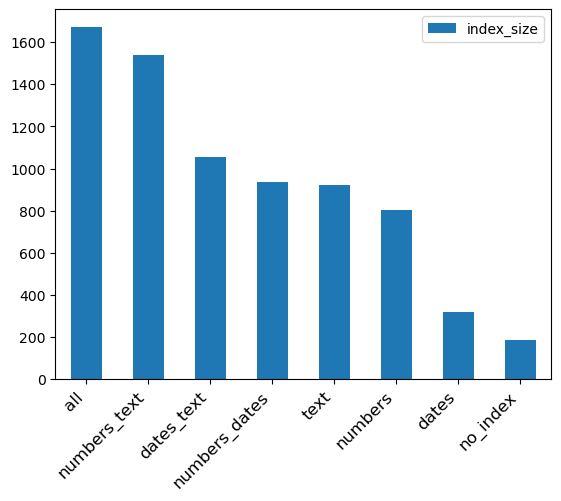

In [38]:
create_barplot(data, "sf1")

<Figure size 800x800 with 0 Axes>

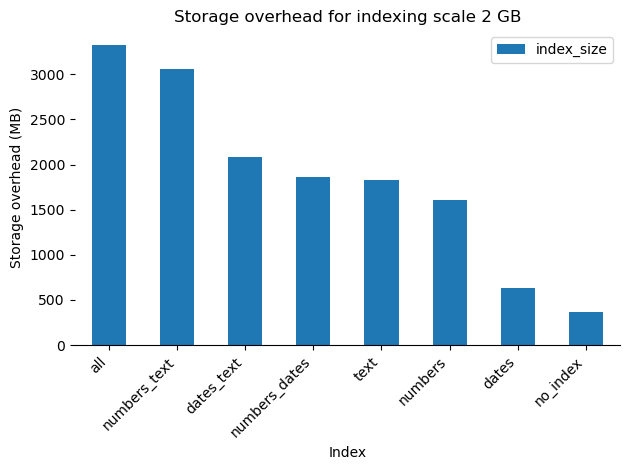

In [25]:
create_barplot(data, "sf2")


<Figure size 800x800 with 0 Axes>

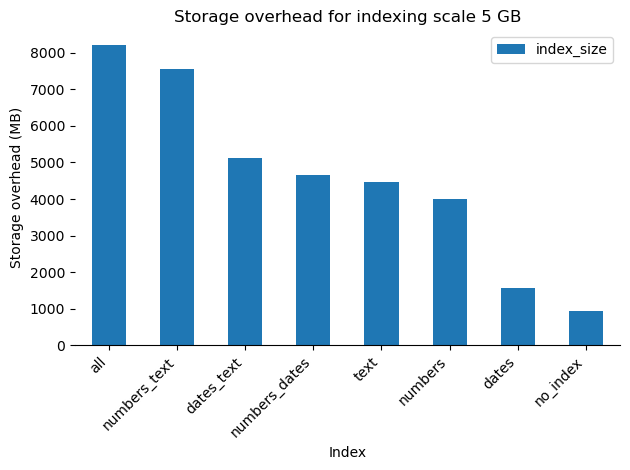

In [22]:
create_barplot(data, "sf5")
